In [ ]:

# Packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sys

# CONFIGURATION SETTINGS

# Data settings
VALIDATION_SPLIT = 0.2              # 20% of data held out for validation
FEATURE_COLUMNS_START = 1           # Which column do features start? (0-indexed)
                                    # Column 0 is assumed to be option_price

# Training settings
NUM_EPOCHS = 10                     # Number of complete passes through data
BATCH_SIZE = 32                     # Number of samples per training batch
LEARNING_RATE = 0.001               # Step size for gradient descent

# Monte Carlo settings
NUM_SIMULATIONS = 100               # Number of price paths to simulate
NUM_STEPS_MULTIPLIER = 50           # Time steps per year (50 for testing, 252 for real)

# Model settings
USE_JUMPS = True                   # False = Heston (5 params), True = Bates (8 params)
USE_MANUAL_GRADIENTS = True         # True = Finite differences, False = TensorFlow auto (broken)
GRADIENT_EPSILON = 1e-4             # Small perturbation for finite differences


In [ ]:

# PART 1: LOAD HISTORICAL OPTIONS DATA


# X is the feature data, Y is the Target
def load_historical_options_data(filepath, target_col_index=14, other_cols_to_drop=None):
    if other_cols_to_drop is None: other_cols_to_drop = []
    try:
        if filepath.lower().endswith('.csv'):
            df = pd.read_csv(filepath)
        else:
            # Defaults to Excel for .xlsx, .xls, etc.
            df = pd.read_excel(filepath)

    except Exception as e:
        return None, None, None

      # 2. Extract Target (y)
    try:
        y = df.iloc[:, target_col_index].values
        y = pd.to_numeric(y, errors='coerce')
    except IndexError:
        return None, None, None

    # 3. Extract Features (X)
    # Exclude Target and the 'other_cols_to_drop'
    cols_to_exclude = list(set([target_col_index] + other_cols_to_drop))
    df_features = df.drop(df.columns[cols_to_exclude], axis=1)

    # Save feature names for later reference
    feature_names = list(df_features.columns)

    # Force all data to numeric (coercing errors to NaN)
    # This handles "dates" by turning them into NaNs, which we filter out next.
    X = df_features.apply(pd.to_numeric, errors='coerce').values
    X[np.isinf(X)] = np.nan

    # B. Filter rows with NaNs (in either X or y)
    # This removes rows where text/dates couldn't be converted, or empty cells exist
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)


    X = X[valid_mask]
    y = y[valid_mask]

    # C. Fix Constant Columns
    # If a column (like 'r' or 'q') never changes, std_dev is 0, causing division by zero errors, so this fixes that by add tiny noise to these columns to make the math work.
    std_devs = np.nanstd(X, axis=0)
    constant_cols = np.where(std_devs == 0)[0]



    return X, y, feature_names


In [ ]:
filename = "spxData_fixed.csv"
df=pd.read_csv(filename)
target_col="Mid"
columns_to_keep = ['Implied Volatility', 'Last', 'Volume', 'Strike', 'DaysToExpiry', 'Spot', 'Tau', 'r', 'q', 'Forward', 'LogMoneyness']
y=

In [ ]:
filename = "spxData_fixed.csv"

TARGET_COLUMN = 17
Columns_to_ignore = [0, 1, 4, 5, 6, 7, 9, 11, 13, 16, 18]

X, y, features = load_historical_options_data(filename,target_col_index=TARGET_COLUMN,other_cols_to_drop= Columns_to_ignore)
print(X[1])
print(y[1])
print(features)

[ 2.12698000e+01  1.14700000e+02  1.11000000e+02  3.75000000e+03
  1.70000000e+01  3.82413989e+03  4.65753420e-02  4.25500010e-02
  1.50000000e-02  3.82904999e+03 -2.08608880e-02]
115.85
['Implied Volatility', 'Last', 'Volume', 'Strike', 'DaysToExpiry', 'Spot', 'Tau', 'r', 'q', 'Forward', 'LogMoneyness']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =============================================================================
# PART 2: NEURAL NETWORK (WITH BUILT-IN PHYSICS SCALING)
# =============================================================================
from tensorflow.keras import layers, models
def ScalerLayer(x):
    """
    Custom Keras Layer that scales [0,1] sigmoid outputs to Heston ranges.
    This runs INSIDE the model graph, so gradients work perfectly.
    """
    # 1. Split the [Batch, 5] input into 5 separate vectors
    # (We assume 5 parameters for Heston, or 8 for Bates)

    # Theta (Long-run Var): [0.01, 0.5]
    theta = x[:, 0:1] * 0.49 + 0.01

    # Rho (Correlation): [-0.99, -0.01] (Negative)
    rho   = x[:, 1:2] * (-0.98) - 0.01

    # V0 (Initial Var): [0.01, 0.5]
    v0    = x[:, 2:3] * 0.49 + 0.01

    # Xi (Vol of Vol): [0.01, 1.0]
    xi    = x[:, 3:4] * 0.99 + 0.01

    # Kappa (Mean Reversion): [0.1, 20.0]
    kappa = x[:, 4:5] * 19.9 + 0.1

    # If we have 8 columns (Jumps), handle them
    if x.shape[-1] == 8:
        muJ    = x[:, 5:6] * 0.4 - 0.2
        sigmaJ = x[:, 6:7] * 0.19 + 0.01
        lam    = x[:, 7:8] * 5.0
        # Recombine into one matrix
        return tf.concat([theta, rho, v0, xi, kappa, muJ, sigmaJ, lam], axis=1)

    # Recombine into one matrix [Batch, 5]
    return tf.concat([theta, rho, v0, xi, kappa], axis=1)


def build_calibration_neural_network(X_train, num_params=5):
    print("\n" + "="*70)
    print(f"BUILDING PHYSICS-INFORMED NEURAL NETWORK ({num_params} Params)")
    print("="*70)

    num_features = X_train.shape[1]

    # 1. Normalization Layer (Learns mean/std of your inputs)
    normalizer = layers.Normalization(axis=-1, name='input_normalization')
    normalizer.adapt(X_train)

    model = models.Sequential([
        layers.Input(shape=(num_features,)),

        # Normalize inputs (S0~4000 -> 0.0, T~0.1 -> 0.0)
        normalizer,

        # Hidden Layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),

        # Raw Output Layer (Sigmoid -> 0 to 1)
        layers.Dense(num_params, activation='sigmoid', name='raw_0_1_output'),

        # SCALING LAYER (The Physics Logic)
        # Converts 0..1 to Kappa, Rho, etc. automatically
        layers.Lambda(ScalerLayer, name='physics_scaling')
    ], name='heston_calibration_network')

    return model


In [ ]:
# =============================================================================
# COMPLETE PART 3: PHYSICS ENGINE & TESTING (ALL-IN-ONE)
# =============================================================================
import tensorflow as tf
import numpy as np

# Set precision
tf.keras.backend.set_floatx('float64')

# ---------------------------------------------------------
# 1. ROBUST COLUMN FINDER
# ---------------------------------------------------------
def get_column_index(name_list, search_terms):
    """Finds column index, prioritizing exact matches to avoid bugs."""
    name_list_lower = [str(n).lower() for n in name_list]

    # Priority A: Exact Match (Fixes 'r' vs 'Strike')
    for term in search_terms:
        if term.lower() in name_list_lower:
            return name_list_lower.index(term.lower())

    # Priority B: Partial Match
    for term in search_terms:
        if len(term) < 2: continue
        for i, name in enumerate(name_list_lower):
            if term.lower() in name:
                return i
    raise ValueError(f"Could not find a column matching {search_terms}")

# ---------------------------------------------------------
# 2. SCALER FUNCTION (Redefined to ensure order)
# ---------------------------------------------------------
def scale_parameters_to_heston_ranges(raw_outputs):
    """
    Scales [0,1] inputs to physics ranges.
    Returns Tuple: (theta, rho, v0, xi, kappa)
    """
    # 1. Theta [0.01, 0.5]
    theta = raw_outputs[:, 0:1] * 0.49 + 0.01

    # 2. Rho [-0.99, -0.01] (Negative!)
    rho   = raw_outputs[:, 1:2] * (-0.98) - 0.01

    # 3. V0 [0.01, 0.5]
    v0    = raw_outputs[:, 2:3] * 0.49 + 0.01

    # 4. Xi [0.01, 1.0]
    xi    = raw_outputs[:, 3:4] * 0.99 + 0.01

    # 5. Kappa [0.1, 20.0]
    kappa = raw_outputs[:, 4:5] * 19.9 + 0.1

    # Check for Jumps (8 cols)
    if raw_outputs.shape[-1] == 8:
        muJ    = raw_outputs[:, 5:6] * 0.4 - 0.2
        sigmaJ = raw_outputs[:, 6:7] * 0.19 + 0.01
        lam    = raw_outputs[:, 7:8] * 5.0
        return theta, rho, v0, xi, kappa, muJ, sigmaJ, lam

    return theta, rho, v0, xi, kappa

# ---------------------------------------------------------
# 3. MONTE CARLO ENGINE (TensorFlow)
# ---------------------------------------------------------
def generate_heston_paths_tf(S0, T, r, q, kappa, theta, v0, rho, xi,
                             muJ=None, sigmaJ=None, lam=None,
                             num_simulations=100, num_steps=10): #will have to bump this up when actually doing it

    # Cast & Reshape [Batch, 1]
    S0 = tf.reshape(tf.cast(S0, tf.float64), [-1, 1])
    T  = tf.reshape(tf.cast(T, tf.float64),  [-1, 1])
    r  = tf.reshape(tf.cast(r, tf.float64),  [-1, 1])
    q  = tf.reshape(tf.cast(q, tf.float64),  [-1, 1])

    v0 = tf.reshape(tf.cast(v0, tf.float64), [-1, 1])
    kappa = tf.reshape(tf.cast(kappa, tf.float64), [-1, 1])
    theta = tf.reshape(tf.cast(theta, tf.float64), [-1, 1])
    xi = tf.reshape(tf.cast(xi, tf.float64), [-1, 1])
    rho = tf.reshape(tf.cast(rho, tf.float64), [-1, 1]) # [-1, 1] range

    batch_size = tf.shape(S0)[0]
    dt = T / num_steps
    sqrt_dt = tf.sqrt(dt)

    # Init Paths
    S_t = tf.tile(S0, [1, num_simulations])
    v_t = tf.tile(v0, [1, num_simulations])

    # Jumps Setup
    use_jumps = (muJ is not None)
    if use_jumps:
        muJ = tf.reshape(tf.cast(muJ, tf.float64), [-1, 1])
        sigmaJ = tf.reshape(tf.cast(sigmaJ, tf.float64), [-1, 1])
        lam = tf.reshape(tf.cast(lam, tf.float64), [-1, 1])
        kappaJ = tf.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    else:
        lam = tf.zeros([batch_size, 1], dtype=tf.float64)
        kappaJ = tf.zeros([batch_size, 1], dtype=tf.float64)

    # Loop
    for t in range(num_steps):
        Z1 = tf.random.normal(shape=(batch_size, num_simulations), dtype=tf.float64)
        Z2_uncorr = tf.random.normal(shape=(batch_size, num_simulations), dtype=tf.float64)
        Z2 = rho * Z1 + tf.sqrt(1.0 - rho**2) * Z2_uncorr

        # Heston
        v_t_pos = tf.maximum(v_t, 0.0)
        sqrt_v_t = tf.sqrt(v_t_pos)
        dv = kappa * (theta - v_t_pos) * dt + xi * sqrt_v_t * sqrt_dt * Z2
        v_t = v_t + dv

        # Jumps
        Jump_term = 0.0
        if use_jumps:
            jump_prob = lam * dt
            u_jump = tf.random.uniform(shape=(batch_size, num_simulations), dtype=tf.float64)
            is_jump = tf.cast(u_jump < jump_prob, tf.float64)
            Z_jump = tf.random.normal(shape=(batch_size, num_simulations), dtype=tf.float64)
            Jump_term = is_jump * (muJ + sigmaJ * Z_jump)

        # Stock
        drift = (r - q - 0.5 * v_t_pos - lam * kappaJ) * dt
        diffusion = sqrt_v_t * sqrt_dt * Z1
        S_t = S_t * tf.exp(drift + diffusion + Jump_term)

    return S_t

def price_batch_tf(X_batch, predicted_params, feature_names):
    # Map
    idx_S0 = get_column_index(feature_names, ['Spot', 'S0', 'Underlying'])
    idx_K  = get_column_index(feature_names, ['Strike', 'K'])
    idx_T  = get_column_index(feature_names, ['Tau', 'Time', 'Days', 'T'])
    idx_r  = get_column_index(feature_names, ['r', 'Rate', 'Interest'])
    idx_q  = get_column_index(feature_names, ['q', 'Div', 'Yield'])

    S0 = X_batch[:, idx_S0]; K = X_batch[:, idx_K]
    T  = X_batch[:, idx_T];  r = X_batch[:, idx_r]
    q  = X_batch[:, idx_q]

    # Unpack Params - ORDER MATTERS HERE
    # [theta, rho, v0, xi, kappa]
    theta = predicted_params[:, 0]
    rho   = predicted_params[:, 1] # <--- Check this matches scaler
    v0    = predicted_params[:, 2]
    xi    = predicted_params[:, 3]
    kappa = predicted_params[:, 4]

    muJ, sigmaJ, lam = None, None, None
    if predicted_params.shape[1] == 8:
        muJ    = predicted_params[:, 5]
        sigmaJ = predicted_params[:, 6]
        lam    = predicted_params[:, 7]

    final_prices = generate_heston_paths_tf(
        S0, T, r, q, kappa, theta, v0, rho, xi, muJ, sigmaJ, lam,
        num_simulations=2000, num_steps=30
    )

    payoffs = tf.maximum(final_prices - tf.reshape(K, [-1, 1]), 0.0)
    return tf.exp(-r * T) * tf.reduce_mean(payoffs, axis=1)



In [ ]:
z# =============================================================================
# PART 4 & 5: THE PHYSICS-INFORMED TRAINER (TensorFlow Auto-Diff)
# =============================================================================
import time

class HestonCalibrationTrainer:
    def __init__(self, model, feature_names, learning_rate=0.001):
        self.model = model
        self.feature_names = feature_names # Needed to map columns inside the loop
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        # Metric trackers
        self.loss_history = []

    @tf.function # <--- This compiles the function for extreme speed
    def train_step(self, X_batch, y_batch):
        """
        The Magic Step:
        1. NN predicts Params
        2. TF simulates Prices (Monte Carlo)
        3. Calculate Error
        4. TF calculates gradients ALL THE WAY BACK to the NN weights
        """
        # Ensure data is Float64
        X_batch = tf.cast(X_batch, tf.float64)
        y_batch = tf.cast(y_batch, tf.float64)

        with tf.GradientTape() as tape:
            # A. Forward Pass (Neural Network)
            # The Scaler is built INTO the model, so 'params' are already valid (Theta, Rho...)
            params = self.model(X_batch, training=True)

            # B. Physics Pass (Monte Carlo)
            # We pass the predicted params into the engine
            pred_prices = price_batch_tf(X_batch, params, self.feature_names)

            # C. Loss Calculation (MSE)
            # We compare Model Price vs Market Price
            loss = tf.reduce_mean(tf.square(y_batch - pred_prices))

        # D. Backpropagation
        # Calculate gradients of Loss with respect to Model Weights
        grads = tape.gradient(loss, self.model.trainable_variables)

        # Update Weights
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss, pred_prices

    def train(self, X_train, y_train, batch_size=32, epochs=10):
        print(f"\nStarting Training on {len(X_train)} options...")
        print(f"Batch Size: {batch_size}, Epochs: {epochs}")

        # Convert entire dataset to Tensor (Float64) once
        X_train_tf = tf.cast(X_train, tf.float64)
        y_train_tf = tf.cast(y_train, tf.float64)

        # Create Data Loader
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

        for epoch in range(epochs):
            start_time = time.time()
            epoch_loss_avg = tf.keras.metrics.Mean()

            # Loop through batches
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

                # Run the training step
                loss, pred_prices = self.train_step(x_batch_train, y_batch_train)
                epoch_loss_avg.update_state(loss)

                # Optional: Print every 10 batches
                if step % 10 == 0:
                    print(f".", end="", flush=True)

            # End of Epoch
            avg_loss = epoch_loss_avg.result()
            self.loss_history.append(avg_loss)

            # Calculate MAE (Mean Absolute Error) in Dollars
            # Just taking the last batch to show progress
            mae = tf.reduce_mean(tf.abs(y_batch_train - pred_prices))

            print(f"\nEpoch {epoch+1}/{epochs} | Loss (MSE): {avg_loss:.4f} | Avg Error (MAE): ${mae:.2f} | Time: {time.time()-start_time:.1f}s")

        print("\n Training Complete.")


PHYSICS-INFORMED NEURAL NETWORK CALIBRATION
Loading data from spxData_fixed.csv...

⚠️ RUNNING IN FAST TEST MODE (First 50 samples only)
Training Samples: 40
Validation Samples: 10

BUILDING PHYSICS-INFORMED NEURAL NETWORK (8 Params)

Starting Training...

Starting Training on 40 options...
Batch Size: 64, Epochs: 10
.
Epoch 1/10 | Loss (MSE): 40878.4751 | Avg Error (MAE): $188.64 | Time: 13.7s
.
Epoch 2/10 | Loss (MSE): 39194.8885 | Avg Error (MAE): $185.85 | Time: 0.6s
.
Epoch 3/10 | Loss (MSE): 32266.6303 | Avg Error (MAE): $173.07 | Time: 0.4s
.
Epoch 4/10 | Loss (MSE): 29371.4858 | Avg Error (MAE): $163.42 | Time: 0.6s
.
Epoch 5/10 | Loss (MSE): 30491.3384 | Avg Error (MAE): $164.81 | Time: 0.4s
.
Epoch 6/10 | Loss (MSE): 25610.1541 | Avg Error (MAE): $155.12 | Time: 0.6s
.
Epoch 7/10 | Loss (MSE): 23462.0852 | Avg Error (MAE): $145.86 | Time: 0.4s
.
Epoch 8/10 | Loss (MSE): 22396.9768 | Avg Error (MAE): $144.18 | Time: 0.6s
.
Epoch 9/10 | Loss (MSE): 20699.7762 | Avg Error (MAE)

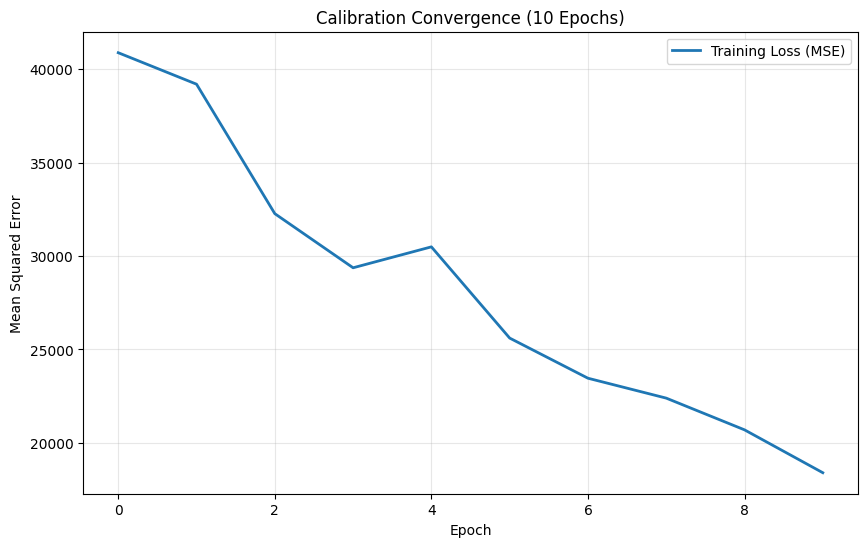


FINAL VALIDATION: MODEL vs MARKET
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

Option 1:
  Market Price: $299.90
  Model Price:  $515.77
  Error:        $215.87 (72.0%)
  Learned Params:
    Theta (LongVar): 0.1083
    Rho (Corr):      -0.5808
    V0 (Vol):        0.2131
    Kappa (Revert):  13.28
    Jumps (Lambda):       2.29

Option 2:
  Market Price: $138.10
  Model Price:  $346.70
  Error:        $208.60 (151.1%)
  Learned Params:
    Theta (LongVar): 0.2455
    Rho (Corr):      -0.5019
    V0 (Vol):        0.2528
    Kappa (Revert):  10.19
    Jumps (Lambda):       2.53

Option 3:
  Market Price: $65.45
  Model Price:  $241.52
  Error:        $176.07 (269.0%)
  Learned Params:
    Theta (LongVar): 0.2026
    Rho (Corr):      -0.5706
    V0 (Vol):        0.2250
    Kappa (Revert):  9.54
    Jumps (Lambda):       2.65

Option 4:
  Market Price: $18.95
  Model Price:  $111.41
  Error:        $92.46 (487.9%)
  Learned Params:
    Theta (LongVar): 0.2359
    Rho (Corr):      -0.5273
    V

In [ ]:
# =============================================================================
# MAIN EXECUTION (UPDATED FOR TENSORFLOW WORKFLOW)
# =============================================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
# Change this to your actual file name!
FILEPATH = "spxData_fixed.csv"

# Model Settings
USE_JUMPS = True          # True = 8 params (Bates), False = 5 params (Heston)
NUM_PARAMS = 8 if USE_JUMPS else 5

# Training Settings
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 200                # Start small to test, then increase to 50+

def main():
    print("\n" + "="*70)
    print("PHYSICS-INFORMED NEURAL NETWORK CALIBRATION")
    print("="*70)

    # -------------------------------------------------------------------------
    # PART 1: LOAD DATA
    # -------------------------------------------------------------------------
    # Based on our debugging session, these were the columns to remove
    # (Bid/Ask, Text Ref, Dates, Duplicate Prices)
    COLS_TO_IGNORE = [0, 1, 3, 4, 5, 6, 7, 9, 11, 13, 16, 18]
    TARGET_COLUMN = 17

    print(f"Loading data from {FILEPATH}...")
    X, y, feature_names = load_historical_options_data(
        FILEPATH,
        target_col_index=TARGET_COLUMN,
        other_cols_to_drop=COLS_TO_IGNORE
    )
    print("\n RUNNING IN FAST TEST MODE (First 50 samples only)")
    X = X[:50]
    y = y[:50]
    EPOCHS = 10

    if X is None:
        print(" Critical Error: Data failed to load.")
        return

    # Split Data (80% Train, 20% Val)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training Samples: {len(X_train)}")
    print(f"Validation Samples: {len(X_val)}")

    # -------------------------------------------------------------------------
    # PART 2: BUILD NEURAL NETWORK
    # -------------------------------------------------------------------------
    # We pass X_train so the normalization layer adapts to the data range
    model = build_calibration_neural_network(X_train, num_params=NUM_PARAMS)

    # -------------------------------------------------------------------------
    # PARTS 3-5: TRAIN THE MODEL (Backpropagation check happens here!)
    # -------------------------------------------------------------------------
    trainer = HestonCalibrationTrainer(
        model,
        feature_names=feature_names, # Needed for column mapping inside TF
        learning_rate=LEARNING_RATE
    )

    print("\nStarting Training...")
    # This runs the Training Loop we defined in the previous step
    trainer.train(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

    # -------------------------------------------------------------------------
    # VISUALIZE RESULTS
    # -------------------------------------------------------------------------
    print("\nPlotting Loss Curve...")
    plt.figure(figsize=(10, 6))
    plt.plot(trainer.loss_history, label='Training Loss (MSE)', linewidth=2)
    plt.title(f'Calibration Convergence ({EPOCHS} Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # -------------------------------------------------------------------------
    # VALIDATION CHECK
    # -------------------------------------------------------------------------
    print("\n" + "="*70)
    print("FINAL VALIDATION: MODEL vs MARKET")
    print("="*70)

    # Take 5 random samples from validation set
    sample_indices = np.random.choice(len(X_val), 5, replace=False)
    X_sample = X_val[sample_indices]
    y_sample = y_val[sample_indices]

    # A. Get Predicted Parameters
    # Note: We do NOT call a scaler function here.
    # The scaler is built INTO the model now (Part 2 update).
    predicted_params = model.predict(X_sample)

    # B. Run Monte Carlo with these parameters
    # Must convert to Tensor for the pricing engine
    params_tensor = tf.convert_to_tensor(predicted_params, dtype=tf.float64)
    X_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float64)

    # Run Price Engine
    model_prices = price_batch_tf(X_tensor, params_tensor, feature_names).numpy()

    # C. Display Results
    for i in range(5):
        mkt_price = y_sample[i]
        mdl_price = model_prices[i]
        diff = mdl_price - mkt_price
        pct_err = (diff / mkt_price) * 100 if mkt_price != 0 else 0

        print(f"\nOption {i+1}:")
        print(f"  Market Price: ${mkt_price:.2f}")
        print(f"  Model Price:  ${mdl_price:.2f}")
        print(f"  Error:        ${diff:.2f} ({pct_err:.1f}%)")

        # Display the "Why" (The learned parameters)
        p = predicted_params[i]
        print("  Learned Params:")
        print(f"    Theta (LongVar): {p[0]:.4f}")
        print(f"    Rho (Corr):      {p[1]:.4f}")
        print(f"    V0 (Vol):        {p[2]:.4f}")
        print(f"    Kappa (Revert):  {p[4]:.2f}")
        if NUM_PARAMS == 8:
             print(f"    Jumps (Lambda):       {p[7]:.2f}")

if __name__ == "__main__":
    main()

In [ ]:
 # -------------------------------------------------------------------------
    # SAVE MODEL
    # -------------------------------------------------------------------------

    model.save('heston_calibration_model.keras')
    print(f"\n✓ Model saved to: heston_calibration_model.keras")

    # Save history
    history_df = pd.DataFrame(history)
    history_df.to_csv('training_history.csv', index=False)
    print(f"✓ Training history saved to: training_history.csv")

    print("\n" + "="*70)
    print("ALL DONE!")
    print("="*70)


if __name__ == "__main__":
    main()